# Multimodal Speech Emotion Recognition - Demo app
<hr/>
<b>Description:</b> This notebook contains a demo application of  Emotion Recognition models trained on the IEMOCAP dataset using 4 basic emotions.<br/>
<b>Model Architecture:</b> Electra small (TER), TRILL (SER), YAMNet (SER), Electra + TRILL (MER), Electra + YAMNet (MER)<br/>
<b>Author:</b> Jan Čuhel<br/>
<b>Date:</b> 3.5.2021<br/>
<b>Dataset:</b> <a href='https://usc.edu/iemocap/'>IEMOCAP</a><br/>
<b>Emotions:</b> Basic - [happy + excited, sad, angry, neutral]<br/>


###Resources 
- https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
- https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
- https://getemoji.com/
- https://realpython.com/python-speech-recognition/
- https://github.com/Uberi/speech_recognition#readme
- https://www.howtogeek.com/423214/how-to-use-the-rename-command-on-linux/

## Code preparation
### Please run this code cell (`Shift + Enter`)

What this does:

1.   Installs the required Python packages
2.   Clones a Github repository containing classes for Emotion Recognition models
3.   Downloads the trained saved models
4.   Moves the downloaded trained saved models


In [1]:
# Step 1) Installation
!pip install -q ffmpeg-python SpeechRecognition gTTS pydub librosa tensorflow-text

# Step 2) Connect to GitHub
!git clone https://github.com/HonzaCuhel/mer-thesis-app

# Step 3) Download the models
!wget 'https://alquist2021-data.s3.amazonaws.com/public/mer_electra_yamnet_iemocap_model+(1).h5'
!wget 'https://alquist2021-data.s3.amazonaws.com/public/mer_trill_electra_small_model.h5'
!wget 'https://alquist2021-data.s3.amazonaws.com/public/ter_electra_iemocap_model+(1).h5'
!wget 'https://alquist2021-data.s3.amazonaws.com/public/ter_electra_model_psychexp.h5'

# Step 4) Moves the models
!mv '/content/mer_electra_yamnet_iemocap_model+(1).h5' /content/mer-thesis-app/result_models/mer_electra_yamnet_iemocap_model.h5
!mv '/content/mer_trill_electra_small_model.h5' /content/mer-thesis-app/result_models/mer_trill_electra_small_model.h5
!mv '/content/ter_electra_iemocap_model+(1).h5' /content/mer-thesis-app/result_models/ter_electra_iemocap_model.h5
!mv '/content/ter_electra_model_psychexp.h5' /content/mer-thesis-app/result_models/ter_electra_model_psychexp.h5

     |████████████████████████████████| 32.8MB 120kB/s 
     |████████████████████████████████| 3.4MB 61.6MB/s 
Cloning into 'mer-thesis-app'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.
--2021-05-04 09:23:27--  https://alquist2021-data.s3.amazonaws.com/public/mer_electra_yamnet_iemocap_model+(1).h5
Resolving alquist2021-data.s3.amazonaws.com (alquist2021-data.s3.amazonaws.com)... 52.216.95.107
Connecting to alquist2021-data.s3.amazonaws.com (alquist2021-data.s3.amazonaws.com)|52.216.95.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187908296 (179M) [application/x-www-form-urlencoded]
Saving to: ‘mer_electra_yamnet_iemocap_model+(1).h5’

mer_electra_yamnet_ 100%[===================>] 179.20M  33.9MB/s    in 5.9s    

2021-05-04 09:23:33 (30.4 MB/s) - ‘mer_electra_yamnet_iemocap_model+(1).h5’ saved [187908296/187908296]

--2021-05-04 09:23:33--  https://alqui

## Code definition
### Please run this code cell (`Shift + Enter`) as well

What this does:

1.   Imports the required packeges
2.   Defines some constants
3.   Load the trained models
4.   Defines functions for Emotion Recognition

In [2]:
# Step 1) Imports
import sys
import gtts
import os
import IPython.display as display
import matplotlib.pyplot as plt
import librosa
import speech_recognition as sr

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/content/mer-thesis-app/')
from record_audio import get_audio
from predict_emotion_tf import *


# Step 2) Defining constants
lang = 'en'
dur = 11
emoji_dict = {"happy":"😊", "fear":"😱", "angry":"😡", "sad":"😢", "disgust":"🤮", "shame":"😳", "guilt":"😓", "neutral": "😐"}
NO = 'no'
DEFAULT_SAMPLE_RATE = 16000
output_file = 'output_emotion.mp3'

# Step 3) Model loading
print('Models are being loaded, it will take some time...')

ser_trill_model_iemocap = TRILLSERModel(SER_TRILL_MODEL_IEMOCAP, TRILL_URL, emotions_iemocap, input_length_iemocap, SAMPLING_RATE)
ser_trill_model_ravdess = TRILLSERModel(SER_TRILL_MODEL_RAVDESS, TRILL_URL, emotions_ravdess, input_length_ravdess, SAMPLING_RATE)
mer_electra_trill_model_iemocap = ElectraTRILLMERModel(MER_ELECTRA_TRILL, TRILL_URL, emotions_iemocap, input_length_iemocap, SAMPLING_RATE)

ser_yamnet_model_iemocap = YAMNetSERModel(SER_YAMNET_MODEL_IEMOCAP, YAMNET_URL, emotions_iemocap, input_length_iemocap, SAMPLING_RATE)
ser_yamnet_model_ravdess = YAMNetSERModel(SER_YAMNET_MODEL_RAVDESS, YAMNET_URL, emotions_ravdess, input_length_ravdess, SAMPLING_RATE)
mer_electra_yamnet_model_iemocap = ElectraYAMNetMERModel(MER_ELECTRA_YAMNET, YAMNET_URL, emotions_iemocap, input_length_iemocap, SAMPLING_RATE)

ter_electra_model_iemocap = TERModel(TER_ELECTRA_IEMOCAP, emotions_iemocap)
ter_electra_model_psychexp = TERModel(TER_ELECTRA_PSYCHEXP, emotion_psychexp)

print('Models are loaded!')

# Step 4) Definition of functions
def get_transription(audio_file):
  # use the audio file as the audio source
  r = sr.Recognizer()
  with sr.AudioFile(audio_file) as source:
      audio = r.record(source, duration=dur)  # read the entire audio file
  
  # Resource: https://github.com/Uberi/speech_recognition/blob/master/examples/audio_transcribe.py
  # Recognize speech using Google Speech Recognition
  try:
      text = r.recognize_google(audio, language=lang)
  except sr.UnknownValueError:
      print("Google Speech Recognition could not understand audio")
      return ""
  except sr.RequestError as e:
      print("Could not request results from Google Speech Recognition service; {0}".format(e))
      return ""
  
  return text

def predict_emotion(audio_file):
  print('Welcome to the Multimodal Speech Emotion Recognizer app from audio and text!')
  print('-'*80)
  print('Help:')
  print(' - record a speech and the program will recognize your emotion')
  # print(f' - to end the program type "{NO}"')

  print('Recognizing emotion...')
  # Recognize the emotion
  text = get_transription(audio_file)

  # TRILL predictions
  ser_trill_iemocap = ser_trill_model_iemocap.predict_emotion(audio_file)
  ser_trill_ravdess = ser_trill_model_ravdess.predict_emotion(audio_file)
  mer_trill_electra = mer_electra_trill_model_iemocap.predict_emotion(text, audio_file)

  # Yamnet predictions
  mer_yamnet_electra = ser_yamnet_model_iemocap.predict_emotion(audio_file)
  ser_yamnet_iemocap = ser_yamnet_model_ravdess.predict_emotion(audio_file)
  ser_yamnet_ravdess = mer_electra_yamnet_model_iemocap.predict_emotion(text, audio_file)

  # TER Electra predictions
  ter_electra_iemocap = ter_electra_model_iemocap.predict_emotion(text)
  ter_electra_psychexp = ter_electra_model_psychexp.predict_emotion(text)

  print('\n' + '='*60)
  print(f'\nYou\'ve said: {text}.\n')
  print("Audio's waveform:")
  plt.figure(figsize=(10,5))
  plt.plot(librosa.load(audio_file)[0])
  plt.title('Audio\'s waveform')
  plt.show()
  print('='*60)
  print("Predictions:")
  print('-'*40)
  print('TRILL models:')
  print(f'MER Electra TRILL (IEMOCAP): {mer_trill_electra}')
  print(f'SER TRILL (IEMOCAP): {ser_trill_iemocap}')
  print(f'SER TRILL (RAVDESS): {ser_trill_ravdess}')
  print('-'*40)
  print('YAMNET models:')
  print(f'MER Electra YAMNet (IEMOCAP): {mer_yamnet_electra}')
  print(f'SER YAMNet (IEMOCAP): {ser_yamnet_iemocap}')
  print(f'SER YAMNet (RAVDESS): {ser_yamnet_ravdess}')
  print('-'*40)
  print('Only text - Electra small')
  print(f'TER Electra small (IEMOCAP): {ter_electra_iemocap}')
  print(f'TER Electra small (RAVDESS): {ter_electra_psychexp}')
  print('='*60)

  return mer_trill_electra

Models are being loaded, it will take some time...


Models are loaded!


### Record a speech

Here you can record a sample of your speach. To record just execute the next cell by either hitting the `run` button or by clicking inside of the cell and then type `Shift + Enter`. After you've sad something click on the button `Stop recording` to stop recording. 

<b>WARNING: ONLY 11 SECONDS OF YOUR SPEECH WILL BE USED, SO IF YOU WILL SPEAK LONGER THE AUDIO FILE WILL BE TRUNCATED, IF YOU WILL SPEAK LESS, IT IS FIME, THE AUDIO RECORDING WILL BE PADDED.</b>

In [15]:
audio, sample_rate, audio_file = get_audio()

print('Speech recorded!')

Speech recorded!


#### Emotion recognition

Welcome to the Multimodal Speech Emotion Recognizer app from audio and text!
--------------------------------------------------------------------------------
Help:
 - record a speech and the program will recognize your emotion
Recognizing emotion...


You've said: I love it.

Audio's waveform:


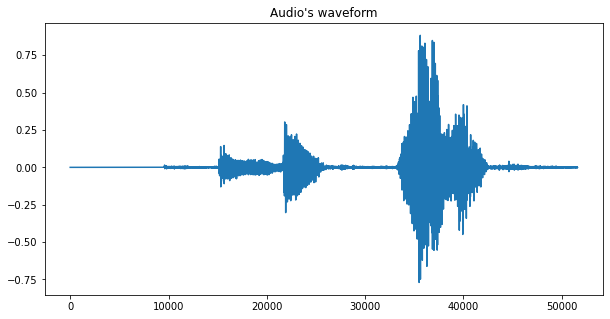

Predictions:
----------------------------------------
TRILL models:
MER Electra TRILL (IEMOCAP): happy
SER TRILL (IEMOCAP): happy
SER TRILL (RAVDESS): surprised
----------------------------------------
YAMNET models:
MER Electra YAMNet (IEMOCAP): neutral
SER YAMNet (IEMOCAP): surprised
SER YAMNet (RAVDESS): neutral
----------------------------------------
Only text - Electra small
TER Electra small (IEMOCAP): happy
TER Electra small (RAVDESS): joy


In [16]:
pred_emotion = predict_emotion(audio_file)

### Audio uploading

You can test out the models by uploading `.wav` audio files and the models will try to predict emotions from them. Try it! 

Saving sad_example.wav to sad_example (1).wav
Saving happy_example.wav to happy_example (1).wav
User uploaded file "sad_example.wav" with length 121846 bytes
********************************************************************************
RESULTS FOR sad_example.wav:
Welcome to the Multimodal Speech Emotion Recognizer app from audio and text!
--------------------------------------------------------------------------------
Help:
 - record a speech and the program will recognize your emotion
Recognizing emotion...


You've said: kids are talking by the door.

Audio's waveform:


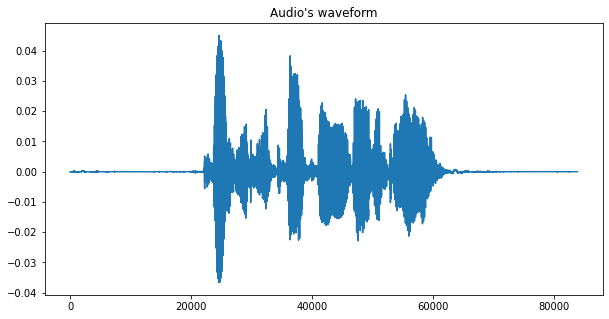

Predictions:
----------------------------------------
TRILL models:
MER Electra TRILL (IEMOCAP): happy
SER TRILL (IEMOCAP): angry
SER TRILL (RAVDESS): sad
----------------------------------------
YAMNET models:
MER Electra YAMNet (IEMOCAP): neutral
SER YAMNet (IEMOCAP): neutral
SER YAMNet (RAVDESS): neutral
----------------------------------------
Only text - Electra small
TER Electra small (IEMOCAP): happy
TER Electra small (RAVDESS): disgust
********************************************************************************
User uploaded file "happy_example.wav" with length 112236 bytes
********************************************************************************
RESULTS FOR happy_example.wav:
Welcome to the Multimodal Speech Emotion Recognizer app from audio and text!
--------------------------------------------------------------------------------
Help:
 - record a speech and the program will recognize your emotion
Recognizing emotion...


You've said: dogs are sitting by the door.


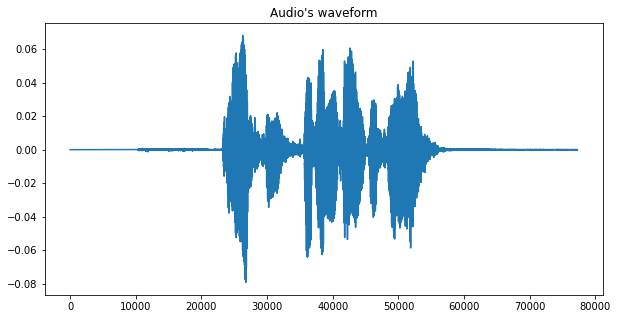

Predictions:
----------------------------------------
TRILL models:
MER Electra TRILL (IEMOCAP): happy
SER TRILL (IEMOCAP): angry
SER TRILL (RAVDESS): happy
----------------------------------------
YAMNET models:
MER Electra YAMNet (IEMOCAP): neutral
SER YAMNet (IEMOCAP): happy
SER YAMNet (RAVDESS): neutral
----------------------------------------
Only text - Electra small
TER Electra small (IEMOCAP): happy
TER Electra small (RAVDESS): fear
********************************************************************************


In [18]:
from google.colab import files

# Upload files
uploaded = files.upload()

for uf in uploaded.keys():
  if '.wav' in uf:
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=uf, length=len(uploaded[uf])))
    
    print('*'*80)
    print(f'RESULTS FOR {uf}:')
    # Predict the emotion
    pred_emotion = predict_emotion(uf)
    print('*'*80)